In [11]:
import numpy as np
from numba import jit, njit, prange
from xoroshiro import *

In [12]:
def CA_SIM(n):
    '''Initializes lattices and random seeds, then begins the
    simulation with CA_HIV. Does not return a value.'''
    grid = np.full((n, n),fill_value = CELL_H, dtype='uint16')
    taugrid = np.zeros_like(grid, dtype='uint16')
    
    
    xoros = np.array([xoroshiro128p_init(np.random.randint(
        low=0,high=18446744073709551610,dtype=np.uint64)) for _ in range(n)])
    
    
    infect(grid, n, xoros)
    return CA_HIV(grid, taugrid, n,xoros)

In [13]:
@jit(nopython=True, parallel=True)
def infect(N, n, xoros):
    '''Seeds a new, healthy grid with infected A1 cells.
        Does not return a value.'''
    for i in prange(n):
        for j in range(n):
            if xoroshiro128p_uniform_float64(xoros[i]) <= P_HIV:
                N[i, j] = CELL_A1

In [14]:
@jit
def eff(P_0j, D_I0, D_I):
    return (P_0j * ((D_I / D_I0) ** ((2 * D_I0) / (1 - D_I0))) * ((1 - D_I) / (1 - D_I0)) ** 2)

In [15]:
# @njit
def CA_HIV(grid, taugrid, n,xoros):
    '''Updates a given lattice 600 times using the rules in step().
    Does not return a value.'''
    buffer = grid.copy()
    counts = np.zeros((601, 7))  # 7 is because there will be 7 cell states.
    for t in range(600 + 1):
        if t < beginTherapy:
            ret = nonTherapyStep(grid=grid, buffer=buffer, taugrid=taugrid, n=n, xoros=xoros)
        else:
            if t == beginTherapy:
                # Save the concentration of infected cells at step treatment begins
                initC = (counts[t-1][-2]+counts[t-1][-3]) / (n ** 2)
                newT = t - 2
                while initC == 0.0:
                    initC = (counts[newT-1][-2]+counts[newT-1][-3]) / (n ** 2)
                    newT -= 1

#                 if t == 301:
#                     pass

            tC=(ret[-2]+ret[-3]) / (n ** 2)
            P_rti = eff(P_0j, initC, tC)
            P_pi = eff(P_0j, initC, tC)

            ret = rtpStep(grid=grid, buffer=buffer, taugrid=taugrid, n=n, xoros=xoros,P_rti=P_rti, P_pi=P_pi)

        grid, buffer = buffer, grid
        
        counts[t] = ret
#         np.save(f'gonz_data/{t}.npy', grid)
    return counts

## Model Parameters and step functions

In [17]:
#Model Parameters
timesteps = 600
P_hiv = 0.05
P_HIV = 0.05
P_repl = 0.99 
P_infec = 1e-05
P_reg=0.99

tauls = 4
tau = 4
beginTherapy=300

CELL_H = 0
CELL_H_rt = 1
CELL_H_p = 2
CELL_H_rtp = 3

CELL_D = 4

CELL_A1 = 84
CELL_A2 = 21

P_0j=0.5

In [18]:
@jit(nopython=True, parallel=True)
def nonTherapyStep(grid, buffer, taugrid, n, xoros):
    H = 0
    H_rt = 0
    H_p = 0
    H_rtp = 0
    A1 = 0
    A2 = 0
    D = 0

    for i in prange(n):
        for j in range(n):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            randNum1 = xoroshiro128p_uniform_float64(xoros[i])
            randNum2 = xoroshiro128p_uniform_float64(xoros[i])
            
            value = grid[i, j]

            if value == CELL_H:
                neighbor_sum = (grid[i - 1, j - 1] + grid[i - 1, j] + grid[i - 1, j + 1] +
                                grid[i, j - 1] + grid[i, j + 1] +
                                grid[i + 1, j - 1] + grid[i + 1, j] + grid[i + 1, j + 1])

                if neighbor_sum >= CELL_A1:
                    buffer[i, j] = CELL_A1
                else:
                    buffer[i, j] = CELL_H

            elif value == CELL_A1:
                taugrid[i, j] += 1
                if taugrid[i, j] == tau:
                    taugrid[i, j] = 0
                    buffer[i, j] = CELL_A2
                else:
                    buffer[i, j] = CELL_A1

            elif value == CELL_A2:
                buffer[i, j] = CELL_D

            else:  # elif value == CELL_D:
                if randNum1 < P_reg:
                    if randNum2 < P_infec:
                        buffer[i, j] = CELL_A1
                    else:
                        buffer[i, j] = CELL_H
                else:
                    buffer[i, j] = CELL_D

            if (value == CELL_H):
                H += 1
            elif (value == CELL_H_rt):
                H_rt += 1
            elif (value == CELL_H_p):
                H_p += 1
            elif(value == CELL_H_rtp):
                H_rtp += 1
            elif (value == CELL_D):
                D += 1
            elif (value == CELL_A1):
                A1 += 1
            else:
                A2+=1
                
    grid, buffer=buffer, grid
    return H, H_rt, H_p, H_rtp, A1, A2, D


In [19]:
# # Step function for cART (both drug therapies)
@jit(nopython=True, parallel=True)
def rtpStep(grid, buffer, taugrid, n, xoros, P_rti, P_pi):
    H = 0
    H_rt = 0
    H_p = 0
    H_rtp = 0
    A1 = 0
    A2 = 0
    D = 0

    for i in prange(n):
        for j in range(n):
            # Note: putting the 'rules' in a seperate function leads to a significant performance impact.
            randNum1 = xoroshiro128p_uniform_float64(xoros[i])
            randNum2 = xoroshiro128p_uniform_float64(xoros[i])
            
            
            value = grid[i, j]
            
            if value == CELL_H:
                if randNum1 <= P_pi:
                    if randNum2 <= P_rti:
                        buffer[i, j] = CELL_H_rtp
                    else:
                        buffer[i, j] = CELL_H_p
                else:
                    if randNum2 <= P_rti:
                        buffer[i, j] = CELL_H_rt
                    else:
                        neighbor_sum = (grid[i - 1, j - 1] + grid[i - 1, j] + grid[i - 1, j + 1] +
                                        grid[i, j - 1] + grid[i, j + 1] +
                                        grid[i + 1, j - 1] + grid[i + 1, j] + grid[i + 1, j + 1])
                        if neighbor_sum >= CELL_A1:
                            buffer[i, j] = CELL_A1
                        else:
                            buffer[i, j] = CELL_H

            elif value == CELL_H_rt:
                if randNum1 <= P_pi:
                    buffer[i, j] = CELL_H_rtp
                else:
                    if randNum2 <= P_rti:
                        buffer[i, j] = CELL_H_rt
                    else:
                        neighbor_sum = (grid[i - 1, j - 1] + grid[i - 1, j] + grid[i - 1, j + 1] +
                                        grid[i, j - 1] + grid[i, j + 1] +
                                        grid[i + 1, j - 1] + grid[i + 1, j] + grid[i + 1, j + 1])
                        if neighbor_sum >= CELL_A1:
                            buffer[i, j] = CELL_A1
                        else:
                            buffer[i, j] = CELL_H

            elif value == CELL_H_p:
                if randNum1 <= P_rti:
                    buffer[i, j] = CELL_H_rtp
                else:
                    if randNum2 <= P_pi:
                        buffer[i, j] = CELL_H_p
                    else:
                        neighbor_sum = (grid[i - 1, j - 1] + grid[i - 1, j] + grid[i - 1, j + 1] +
                                        grid[i, j - 1] + grid[i, j + 1] +
                                        grid[i + 1, j - 1] + grid[i + 1, j] + grid[i + 1, j + 1])
                        if neighbor_sum >= CELL_A1:
                            buffer[i, j] = CELL_A1
                        else:
                            buffer[i, j] = CELL_H

            elif value == CELL_H_rtp:
                buffer[i, j] = CELL_H

            elif value == CELL_A1:
                taugrid[i, j] += 1
                if taugrid[i, j] == tau:
                    taugrid[i, j] = 0
                    buffer[i, j] = CELL_A2
                else:
                    buffer[i, j] = CELL_A1

            elif value == CELL_A2:
                buffer[i, j] = CELL_D

            else:  # elif value == CELL_D:
                if randNum1 <= P_reg:
                    if randNum2 <= P_infec:
                        buffer[i, j] = CELL_A1
                    else:
                        buffer[i, j] = CELL_H
                else:
                    buffer[i, j] = CELL_D

            if (value == CELL_H):
                H += 1
            elif (value == CELL_H_rt):
                H_rt += 1
            elif (value == CELL_H_p):
                H_p += 1
            elif(value == CELL_H_rtp):
                H_rtp += 1
            elif (value == CELL_D):
                D += 1
            elif (value == CELL_A1):
                A1 += 1
            else:
                A2 += 1
                
    #grid, buffer=buffer, grid
    return H, H_rt, H_p, H_rtp, A1, A2, D

## run model

In [20]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 40
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [49]:
reps = 1000
counts = np.zeros([reps, 601, 7])
for run in range(reps):
    update_progress(run / reps)
    counts[run] = CA_SIM(700)
    update_progress((run + 1) / reps)

Progress: [########################################] 100.0%


In [53]:
counts1=np.zeros([reps, 601, 3])
for run in range(reps):
    for t in range(601):
        counts1[run][t][0]=np.sum(counts[run][t][0:4])
        counts1[run][t][1]=np.sum(counts[run][t][4:6])
        counts1[run][t][2]=counts[run][t][-1]

averages = np.array([[np.average(counts1[:, t, i]) for i in range(3)] for t in range(601)])
stdev = np.array([[np.std(counts1[:, t, i]) for i in range(3)] for t in range(601)])

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

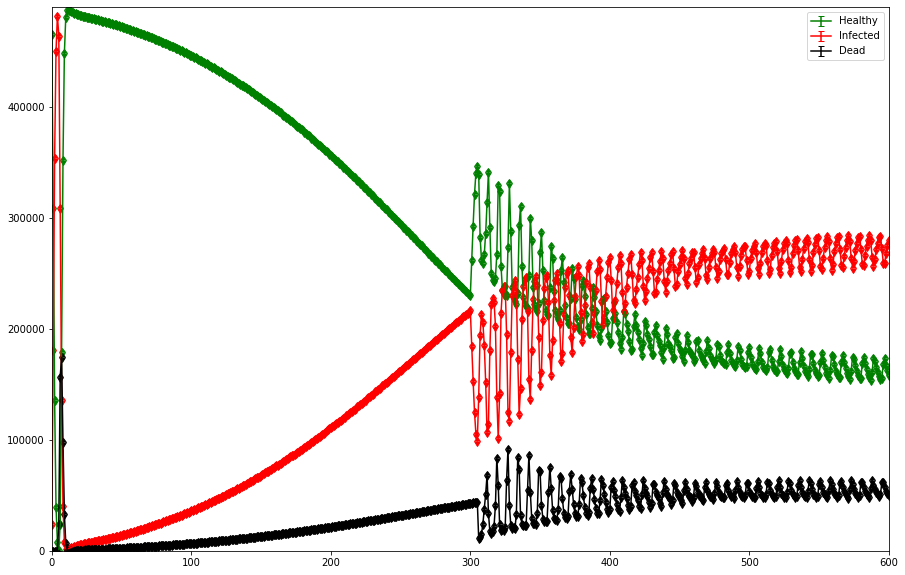

In [57]:
labels = ['Healthy','Infected', 'Dead']
cs = ['g', 'r', 'k']

plt.figure(figsize=(15,10))
for i in range(3):
    # In the figure below, we plot error bars once every 10 timesteps so the
    # plot is less cluttered
    stdev_plot = np.array([stdev[i,:] if i % 10 == 0 else np.zeros(3) for i in range(601)])
    stdev_plot = np.array([np.zeros(3) for _ in range(601)])
    plt.errorbar(range(601), averages[:,i], yerr=stdev_plot[:,i], 
                 uplims=True, lolims=True, 
                 label=labels[i], color=cs[i])

plt.legend(loc='upper right')
plt.ylim([0, 700**2])
plt.xlim([0, 600])
plt.show()

In [168]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# With mac install ffmpeg with brew, $brew install ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

In [169]:
states = [CELL_H, CELL_H_rt, CELL_H_p, CELL_H_rtp, CELL_D, CELL_A1, CELL_A2]
cs = ['g', 'r', 'm', 'y', 'c', 'b', 'k']
mycmap = {k:list(map(lambda x : int(x * 255), matplotlib.colors.to_rgba(v))) for k, v in zip(states, cs)}


labels = ['Healthy', 'Healthy with rt', 'Healthy with p', 'Healthy with rtp',
          'Acute Infected', 'Latent Infected', 'Dead']
names = {k:v for k, v in zip(states, labels)}

In [170]:
arr = []
for t in range(0,601):
    picture = np.load("gonz_data/" + str(t) + '.npy')
    data = np.zeros((100,100,3), dtype=np.uint8)
    for row in range(0, len(data)):
            for col in range(0, len(data)):
                data[row, col] = mycmap[picture[row, col]][:3]
    arr.append(data)

Progress: [########################################] 100.0%


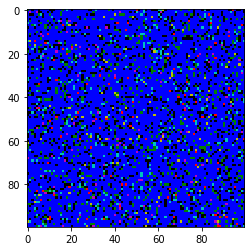

In [171]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2)

fig = plt.figure()
im = plt.imshow(arr[-1], animated=True)
def updatefig(frame, *args):
    update_progress(frame / 601)
    im.set_array(arr[frame])
    update_progress((frame + 1) / 601)
    return im,
ani = animation.FuncAnimation(fig, updatefig, frames=601, blit=True)
ani.save('../Animations/gonz2.mp4', writer=writer, dpi=196)